# **Installing necessary libraries**

In [103]:
#Downloading libraries

%pip install catboost optuna seaborn scikit-learn openpyxl nbformat ipython ipywidgets lightgbm xgboost lazypredict-nightly

Note: you may need to restart the kernel to use updated packages.


In [132]:
# Importing libraries and setting necessery settings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
import optuna
from optuna.samplers import TPESampler
import lazypredict
from lazypredict import LazyRegressor
from catboost import CatBoostRegressor, Pool, cv
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, MaxAbsScaler, LabelEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.svm import SVR
from lightgbm import LGBMRegressor, cv, Dataset
from xgboost import XGBRegressor


%matplotlib inline
plt.style.use("seaborn-v0_8")

# **Basic EDA**

In [105]:
# Readign the file

data = pd.read_csv("final_data.csv", index_col = 0)

In [106]:
# To view some real data

data.head()

,satisfaction,review,projects,avg_hrs_month,tenure,promoted,department,salary
0,0.38,0.53,2,157.00,3.00,0,sales,low
1,0.80,0.86,5,262.00,6.00,0,sales,medium
2,0.11,0.88,7,272.00,4.00,0,sales,medium
3,0.72,0.87,5,223.00,5.00,0,sales,low
4,0.37,0.52,2,159.00,3.00,0,sales,low


In [107]:
# To understand the statistica about the data

data.describe()

,satisfaction,review,projects,avg_hrs_month,tenure,promoted
count,21531.00,21531.00,21531.00,21531.00,21531.00,21531.00
mean,0.57,0.69,3.57,193.47,4.78,0.02
std,0.22,0.14,0.99,37.30,2.09,0.15
min,0.00,0.31,2.00,96.00,2.00,0.00
25%,0.42,0.58,3.00,179.00,3.00,0.00
50%,0.57,0.67,3.00,186.00,5.00,0.00
75%,0.74,0.78,4.00,209.00,6.00,0.00
max,1.00,1.00,7.00,310.00,12.00,1.00


In [108]:
# To know data types and null number

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21531 entries, 0 to 9539
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   satisfaction   21531 non-null  float64
 1   review         21531 non-null  float64
 2   projects       21531 non-null  int64  
 3   avg_hrs_month  21531 non-null  float64
 4   tenure         21531 non-null  float64
 5   promoted       21531 non-null  int64  
 6   department     21531 non-null  object 
 7   salary         21531 non-null  object 
dtypes: float64(4), int64(2), object(2)
memory usage: 1.5+ MB


In [109]:
df = shuffle(data, random_state = 777)
df

,satisfaction,review,projects,avg_hrs_month,tenure,promoted,department,salary
8917,0.59,0.82,3,162.00,2.00,0,IT,high
4664,0.38,0.78,2,182.08,6.00,0,sales,medium
7413,0.36,0.60,3,185.11,7.00,0,sales,low
9654,0.68,0.61,4,227.00,3.00,0,technical,medium
7366,0.61,0.59,4,247.00,2.00,0,technical,medium
...,...,...,...,...,...,...,...,...
4026,0.91,0.93,4,184.00,3.00,0,technical,low
7776,0.83,0.90,3,179.00,2.00,0,product_mng,low
7375,0.32,0.64,3,184.65,7.00,0,retail,medium
3940,0.33,0.83,3,178.84,5.00,0,retail,medium


# **Feature engeneering**

In [110]:
# Combining features

df['workload_intensity'] = (df['projects'] / df['tenure']) * df['avg_hrs_month']
df['relative_project_load'] = (df['projects'] / df['avg_hrs_month']) / df['tenure']
df['hours_per_project'] = df['avg_hrs_month'] / df['projects']
df['experience_weighted_promotion'] = (df['tenure'] * df['promoted']) / (df['tenure'] + 1)
df.head()

,satisfaction,review,projects,avg_hrs_month,tenure,promoted,department,salary,workload_intensity,relative_project_load,hours_per_project,experience_weighted_promotion
8917,0.59,0.82,3,162.00,2.00,0,IT,high,243.00,0.01,54.00,0.00
4664,0.38,0.78,2,182.08,6.00,0,sales,medium,60.69,0.00,91.04,0.00
7413,0.36,0.60,3,185.11,7.00,0,sales,low,79.33,0.00,61.70,0.00
9654,0.68,0.61,4,227.00,3.00,0,technical,medium,302.67,0.01,56.75,0.00
7366,0.61,0.59,4,247.00,2.00,0,technical,medium,494.00,0.01,61.75,0.00


In [111]:
# Polynomial features

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[['projects', 'avg_hrs_month']])
poly_features_df = pd.DataFrame(poly_features, columns=[f'poly_{i}' for i in range(poly_features.shape[1])])
df = df.join(poly_features_df)
df.head()

,satisfaction,review,projects,avg_hrs_month,tenure,promoted,department,salary,workload_intensity,relative_project_load,hours_per_project,experience_weighted_promotion,poly_0,poly_1,poly_2,poly_3,poly_4
8917,0.59,0.82,3,162.00,2.00,0,IT,high,243.00,0.01,54.00,0.00,4.00,134.00,16.00,536.00,17956.00
4664,0.38,0.78,2,182.08,6.00,0,sales,medium,60.69,0.00,91.04,0.00,3.00,109.00,9.00,327.00,11881.00
7413,0.36,0.60,3,185.11,7.00,0,sales,low,79.33,0.00,61.70,0.00,4.00,161.00,16.00,644.00,25921.00
9654,0.68,0.61,4,227.00,3.00,0,technical,medium,302.67,0.01,56.75,0.00,3.00,179.61,9.00,538.83,32259.59
7366,0.61,0.59,4,247.00,2.00,0,technical,medium,494.00,0.01,61.75,0.00,3.00,181.40,9.00,544.20,32905.61


In [115]:
# Encoding salary categorial column

df_encoded = df

le = LabelEncoder()
df_encoded['salary'] = le.fit_transform(df_encoded['salary'])
df_encoded

,review,projects,avg_hrs_month,tenure,promoted,department,salary,workload_intensity,relative_project_load,hours_per_project,experience_weighted_promotion,poly_0,poly_1,poly_2,poly_3,poly_4,satisfaction
8917,0.82,3,162.00,2.00,0,IT,0,243.00,0.01,54.00,0.00,4.00,134.00,16.00,536.00,17956.00,0.59
4664,0.78,2,182.08,6.00,0,sales,2,60.69,0.00,91.04,0.00,3.00,109.00,9.00,327.00,11881.00,0.38
7413,0.60,3,185.11,7.00,0,sales,1,79.33,0.00,61.70,0.00,4.00,161.00,16.00,644.00,25921.00,0.36
9654,0.61,4,227.00,3.00,0,technical,2,302.67,0.01,56.75,0.00,3.00,179.61,9.00,538.83,32259.59,0.68
7366,0.59,4,247.00,2.00,0,technical,2,494.00,0.01,61.75,0.00,3.00,181.40,9.00,544.20,32905.61,0.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4026,0.93,4,184.00,3.00,0,technical,1,245.33,0.01,46.00,0.00,3.00,188.71,9.00,566.13,35611.30,0.91
7776,0.90,3,179.00,2.00,0,product_mng,1,268.50,0.01,59.67,0.00,3.00,195.00,9.00,585.00,38025.00,0.83
7375,0.64,3,184.65,7.00,0,retail,2,79.14,0.00,61.55,0.00,4.00,185.98,16.00,743.92,34588.21,0.32
3940,0.83,3,178.84,5.00,0,retail,2,107.31,0.00,59.61,0.00,3.00,232.00,9.00,696.00,53824.00,0.33


In [116]:
# Encoding department categorial column

ohe = OneHotEncoder(handle_unknown='ignore')
department_encoded = ohe.fit_transform(df_encoded[['department']]).toarray()
department_columns = ohe.categories_[0]
department_df = pd.DataFrame(department_encoded, columns=department_columns)
df_encoded = df_encoded.join(department_df)
df_encoded = df_encoded.drop('department', axis=1)
df_encoded

,review,projects,avg_hrs_month,tenure,promoted,salary,workload_intensity,relative_project_load,hours_per_project,experience_weighted_promotion,...,hr,logistics,management,marketing,operations,product_mng,retail,sales,support,technical
8917,0.82,3,162.00,2.00,0,0,243.00,0.01,54.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
4664,0.78,2,182.08,6.00,0,2,60.69,0.00,91.04,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
7413,0.60,3,185.11,7.00,0,1,79.33,0.00,61.70,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9654,0.61,4,227.00,3.00,0,2,302.67,0.01,56.75,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7366,0.59,4,247.00,2.00,0,2,494.00,0.01,61.75,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4026,0.93,4,184.00,3.00,0,1,245.33,0.01,46.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
7776,0.90,3,179.00,2.00,0,1,268.50,0.01,59.67,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
7375,0.64,3,184.65,7.00,0,2,79.14,0.00,61.55,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3940,0.83,3,178.84,5.00,0,2,107.31,0.00,59.61,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


In [120]:
# Creating the target and feature lists for encoded dataset

target = "satisfaction"
df_encoded_features = [col for col in df_encoded.columns if col != target]
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21531 entries, 8917 to 3160
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   review                         21531 non-null  float64
 1   projects                       21531 non-null  int64  
 2   avg_hrs_month                  21531 non-null  float64
 3   tenure                         21531 non-null  float64
 4   promoted                       21531 non-null  int64  
 5   salary                         21531 non-null  int32  
 6   workload_intensity             21531 non-null  float64
 7   relative_project_load          21531 non-null  float64
 8   hours_per_project              21531 non-null  float64
 9   experience_weighted_promotion  21531 non-null  float64
 10  poly_0                         21531 non-null  float64
 11  poly_1                         21531 non-null  float64
 12  poly_2                         21531 non-null  fl

In [ ]:
# Building 40+ regressors

X_train, X_test, y_train, y_test = train_test_split(df_encoded[df_encoded_features], df_encoded[target],
                                                        test_size = 0.25,
                                                        random_state = 777)

reg = LazyRegressor(ignore_warnings = False)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

 98%|█████████▊| 41/42 [05:01<00:04,  4.56s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2139
[LightGBM] [Info] Number of data points in the train set: 16148, number of used features: 31
[LightGBM] [Info] Start training from score 0.575357


100%|██████████| 42/42 [05:02<00:00,  7.20s/it]


In [52]:
# Searching for the best regressors

predictions["RMSE"].map(lambda x: '%.4f' % x)

Model
HistGradientBoostingRegressor     0.1693
LGBMRegressor                     0.1699
GradientBoostingRegressor         0.1727
RandomForestRegressor             0.1737
ExtraTreesRegressor               0.1762
XGBRegressor                      0.1773
BaggingRegressor                  0.1806
AdaBoostRegressor                 0.1831
NuSVR                             0.1859
SVR                               0.1861
MLPRegressor                      0.1898
KNeighborsRegressor               0.1976
LarsCV                            0.2003
LassoCV                           0.2004
LassoLarsCV                       0.2004
ElasticNetCV                      0.2004
LassoLarsIC                       0.2004
SGDRegressor                      0.2005
BayesianRidge                     0.2005
RidgeCV                           0.2005
Ridge                             0.2005
Lars                              0.2005
TransformedTargetRegressor        0.2005
LinearRegression                  0.2005
Orthogonal

In [53]:
# Building CatBoostRegressor for comparison

model = CatBoostRegressor()

model.fit(X_train, y_train, eval_set = [(X_test, y_test)],
            verbose = False)
preds = model.predict(X_test)
rmse = root_mean_squared_error(y_test, preds)
rmse

0.1692248636040037

# **KNN**

In [35]:
# KNN hyperparameters search using optuna


def objective(trial):
    # split data in training and test data
    X_train, X_test, y_train, y_test = train_test_split(df_encoded[df_encoded_features], df_encoded[target],
                                                        test_size=0.25,
                                                        random_state=777)

    # Instantiate scaler
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust', 'maxabs', None])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    elif scalers == 'maxabs':
        scaler = MaxAbsScaler()
    elif scalers == 'robust':
        scaler = RobustScaler()
    else:
        scaler = None

    # Suggest hyperparameters
    param = { 
        'n_neighbors': trial.suggest_int("n_neighbors", 1, 500),
        'weights': trial.suggest_categorical("weights", ['uniform', 'distance']),
        'metric': trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski',
                                                        'cityblock', 'l1', 'l2']),
        'algorithm': trial.suggest_categorical("algorithm", ['ball_tree', 'kd_tree', 'brute']),
    }
    
    if param["algorithm"] != "brute":
        param["leaf_size"] = trial.suggest_int('leaf_size', 1, 150)

    knn = KNeighborsRegressor(**param)
    
    # Make a pipeline
    pipeline = make_pipeline(scaler, knn)
    pipeline.fit(X_train, y_train)


    # Predict and estimate results
    preds = pipeline.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)

    return rmse


# Opruna study creation for tuning
sampler_knn = TPESampler(multivariate = True, group = True, seed = 777)
study_knn = optuna.create_study(study_name = "knn", sampler = sampler_knn)
study_knn.optimize(objective, n_trials = 100)
trial_knn = study_knn.best_trial
params_knn = study_knn.best_trial.params

# Printing the parameters
print("Number of finished trials: ", len(study_knn.trials))
print("Best trial:", trial_knn.number)
print("  Value: ", trial_knn.value)
print("  Params: ")

for key, value in trial_knn.params.items():
    print("    {}: {}".format(key, value))

[I 2024-06-11 21:59:53,110] A new study created in memory with name: knn
[I 2024-06-11 21:59:53,773] Trial 0 finished with value: 0.03992750433366168 and parameters: {'scalers': None, 'n_neighbors': 464, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'ball_tree', 'leaf_size': 83}. Best is trial 0 with value: 0.03992750433366168.
[I 2024-06-11 21:59:54,123] Trial 1 finished with value: 0.03747363527870273 and parameters: {'scalers': None, 'n_neighbors': 97, 'weights': 'distance', 'metric': 'cityblock', 'algorithm': 'kd_tree', 'leaf_size': 2}. Best is trial 1 with value: 0.03747363527870273.
[I 2024-06-11 21:59:58,044] Trial 2 finished with value: 0.03911262818536387 and parameters: {'scalers': 'standard', 'n_neighbors': 307, 'weights': 'uniform', 'metric': 'l2', 'algorithm': 'kd_tree', 'leaf_size': 52}. Best is trial 1 with value: 0.03747363527870273.
[I 2024-06-11 22:00:01,851] Trial 3 finished with value: 0.03758098796483553 and parameters: {'scalers': 'maxabs', 'n_neighbo

Number of finished trials:  150
Best trial: 53
  Value:  0.027508194330929932
  Params: 
    scalers: robust
    n_neighbors: 28
    weights: distance
    metric: l1
    algorithm: kd_tree
    leaf_size: 71


In [30]:
# History of optimization

optuna.visualization.plot_optimization_history(study_knn)

In [31]:
# Hyperparameters to score dependency

optuna.visualization.plot_slice(study_knn)

In [32]:
# Hyperparameter importances

optuna.visualization.plot_param_importances(study_knn)

In [36]:
# Extracting hyperparameters
del params_knn['scalers']

# Define optimal hyperparameters
scaler_knn = RobustScaler()
knn = KNeighborsRegressor(**params_knn)

# Create pipeline
pipeline_knn = make_pipeline(scaler_knn, knn)

In [37]:
# Implementing cross validation

scores_knn = cross_val_score(pipeline_knn, df_encoded[df_encoded_features], df_encoded[target],  scoring = 'neg_root_mean_squared_error') * (-1)
score_mean_knn = scores_knn.mean()
print(scores_knn, "Средняя оценка:", score_mean_knn)

[0.16472036 0.16160495 0.16586111 0.16476217 0.16657199] Средняя оценка: 0.16470411539336893


# **SVR**

In [17]:
# svr hyperparameters search using optuna


def objective(trial):
    # split data in training and test data
    X_train, X_test, y_train, y_test = train_test_split(df_encoded[df_encoded_features], df_encoded[target],
                                                        test_size=0.25,
                                                        random_state=777)

    # Instantiate scaler
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust', 'maxabs'])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    elif scalers == 'maxabs':
        scaler = MaxAbsScaler()
    elif scalers == 'robust':
        scaler = RobustScaler()
    else:
        scaler = None

    # Suggest hyperparameters
    param = { 
        'gamma': trial.suggest_categorical("gamma", ['scale', 'auto']),
        'C': trial.suggest_float('C', 0, 100),
        'epsilon': trial.suggest_float('epsilon', 0, 1),
        'tol': trial.suggest_float('tol', 0, 0.1),
    }

    svr = SVR(**param)
    
    # Make a pipeline
    pipeline = make_pipeline(scaler, svr)
    pipeline.fit(X_train, y_train)


    # Predict and estimate results
    preds = pipeline.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)

    return rmse


# Opruna study creation for tuning
sampler_svr = TPESampler(multivariate = True, group = True, seed = 777)
study_svr = optuna.create_study(study_name = "svr", sampler = sampler_svr)
study_svr.optimize(objective, n_trials = 150)
trial_svr = study_svr.best_trial
params_svr = study_svr.best_trial.params

# Printing the parameters
print("Number of finished trials: ", len(study_svr.trials))
print("Best trial:", trial_svr.number)
print("  Value: ", trial_svr.value)
print("  Params: ")

for key, value in trial_svr.params.items():
    print("    {}: {}".format(key, value))

[I 2024-06-11 23:10:17,269] A new study created in memory with name: svr
[I 2024-06-11 23:10:17,308] Trial 0 finished with value: 0.22457965602420876 and parameters: {'scalers': 'maxabs', 'gamma': 'auto', 'C': 72.69889843190701, 'epsilon': 0.7684962219206448, 'tol': 0.2692050664721932}. Best is trial 0 with value: 0.22457965602420876.
[I 2024-06-11 23:10:17,339] Trial 1 finished with value: 0.22457965602420876 and parameters: {'scalers': 'minmax', 'gamma': 'auto', 'C': 62.6473206229759, 'epsilon': 0.6817792797809532, 'tol': 0.5522568137371598}. Best is trial 0 with value: 0.22457965602420876.
[I 2024-06-11 23:10:17,387] Trial 2 finished with value: 0.22457965602420876 and parameters: {'scalers': 'standard', 'gamma': 'scale', 'C': 61.09109313551227, 'epsilon': 0.882808447266879, 'tol': 0.6223388243205817}. Best is trial 0 with value: 0.22457965602420876.
[I 2024-06-11 23:10:17,464] Trial 3 finished with value: 0.22457965602420876 and parameters: {'scalers': 'robust', 'gamma': 'auto', 'C

Number of finished trials:  150
Best trial: 126
  Value:  0.1680210615550742
  Params: 
    scalers: robust
    gamma: auto
    C: 28.680993668640735
    epsilon: 0.11732638205434348
    tol: 0.0036284552130216134


In [18]:
# History of optimization

optuna.visualization.plot_optimization_history(study_svr)

In [19]:
# Hyperparameters to score dependency

optuna.visualization.plot_slice(study_svr)

In [20]:
# Hyperparameter importances

optuna.visualization.plot_param_importances(study_svr)

In [24]:
# Extracting hyperparameters
del params_svr['scalers']

# Define optimal hyperparameters
scaler_svr = RobustScaler()
svr = SVR(**params_svr)

# Create pipeline
pipeline_svr = make_pipeline(scaler_svr, svr)

In [25]:
# Implementing cross validation

scores_svr = cross_val_score(pipeline_svr, df_encoded[df_encoded_features], df_encoded[target],  scoring = 'neg_root_mean_squared_error') * (-1)
score_mean_svr = scores_svr.mean()
print(scores_svr, "Средняя оценка:", score_mean_svr)

[0.16732877 0.16755605 0.16866244 0.16922438 0.16985685] Средняя оценка: 0.16852569827471003


# **RandomForest**

In [151]:
# RandomForest hyperparameters search using optuna

def objective(trial):
    # split data in training and test data
    X_train, X_test, y_train, y_test = train_test_split(df_encoded[df_encoded_features], df_encoded[target],
                                                        test_size=0.25,
                                                        random_state=777)

    # Instantiate scaler
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust', 'maxabs', None])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    elif scalers == 'maxabs':
        scaler = MaxAbsScaler()
    elif scalers == 'robust':
        scaler = RobustScaler()
    else:
        scaler = None
    

    # Suggest hyperparameters
    param = { 
        "n_estimators": trial.suggest_int('n_estimators', 50, 1000),
        "max_depth": trial.suggest_int('max_depth', 10, 150),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
   } 
     
    rfr = RandomForestRegressor(
        random_state = 777,
        criterion = 'friedman_mse',
        **param)

    # Make a pipeline
    pipeline = make_pipeline(scaler, rfr)
    pipeline.fit(X_train, y_train)


    # Predict and estimate results
    preds = pipeline.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)

    return rmse

# Opruna study creation for tuning
sampler_rfr = TPESampler(multivariate = True, group = True, seed = 777)
study_rfr = optuna.create_study(study_name = "RFR", sampler = sampler_rfr)
study_rfr.optimize(objective, n_trials = 150)
trial_rfr = study_rfr.best_trial
params_rfr = study_rfr.best_trial.params

# Printing the parameters
print("Number of finished trials: ", len(study_rfr.trials))
print("Best trial:", trial_rfr.number)
print("  Value: ", trial_rfr.value)
print("  Params: ")

for key, value in trial_rfr.params.items():
    print("    {}: {}".format(key, value))

[I 2024-05-19 23:41:49,685] A new study created in memory with name: RFR
[I 2024-05-19 23:42:05,204] Trial 0 finished with value: 0.17074813686866802 and parameters: {'scalers': None, 'n_estimators': 931, 'max_depth': 112, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.17074813686866802.
[I 2024-05-19 23:42:16,476] Trial 1 finished with value: 0.17090043803856325 and parameters: {'scalers': None, 'n_estimators': 645, 'max_depth': 106, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.17074813686866802.
[I 2024-05-19 23:42:54,998] Trial 2 finished with value: 0.17155806344955274 and parameters: {'scalers': None, 'n_estimators': 889, 'max_depth': 97, 'max_features': None}. Best is trial 0 with value: 0.17074813686866802.
[I 2024-05-19 23:42:56,152] Trial 3 finished with value: 0.17127297651233828 and parameters: {'scalers': 'maxabs', 'n_estimators': 62, 'max_depth': 83, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.17074813686866802.
[I 2024-05-19 23:43:06,515] Tria

Number of finished trials:  150
Best trial: 137
  Value:  0.17039856088432723
  Params: 
    scalers: minmax
    n_estimators: 890
    max_depth: 27
    max_features: log2


In [152]:
# History of optimization

optuna.visualization.plot_optimization_history(study_rfr)

In [21]:
# Hyperparameters to score dependency

optuna.visualization.plot_slice(study_rfr)

NameError: name 'study_rfr' is not defined

In [154]:
# Hyperparameter importances

optuna.visualization.plot_param_importances(study_rfr)

In [155]:
# Define optimal hyperparameters
del params_rfr['scalers']
scaler_rfr = MinMaxScaler()
rfr = RandomForestRegressor(**params_rfr, criterion = 'friedman_mse')

# Create pipeline
pipeline_rfr = make_pipeline(scaler_rfr, rfr)

In [156]:
# Implementing cross validation

scores_rfr = cross_val_score(pipeline_rfr, df_encoded[df_encoded_features], df_encoded[target],  scoring = 'neg_root_mean_squared_error') * (-1)
score_mean_rfr = scores_rfr.mean()
print(scores_rfr, "Средняя оценка:", score_mean_rfr)

[0.1453414  0.20959767 0.20842707 0.16439386 0.06375362] Средняя оценка: 0.15830272347743563


# **GBM - CatBoost**

In [119]:
# Find best hyperparameters for Catboost using Optuna library

def objective(trial, data = df_encoded[df_encoded_features], target = df_encoded[target]):

    # Instantiate scaler
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust', 'maxabs', None])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    elif scalers == 'maxabs':
        scaler = MaxAbsScaler()
    elif scalers == 'robust':
        scaler = RobustScaler()
    else:
        scaler = None

    # Transform data
    if scaler != None:
        data = scaler.fit_transform(data, target)
    
    # split data in training and test data
    train_x, test_x, train_y, test_y = train_test_split(data, target,
                                                        test_size=0.25,
                                                        random_state=777)
    # Suggest hyperparameters
    param = {
        "n_estimators": trial.suggest_int('n_estimators', 100, 1000),
        "learning_rate": trial.suggest_float('learning_rate', 0, 1),
        "depth": trial.suggest_int('depth', 4, 16),
        "l2_leaf_reg": trial.suggest_float('l2_leaf_reg', 0, 10),
        "random_strength": trial.suggest_float('random_strength', 0, 10),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        'grow_policy': trial.suggest_categorical('grow_policy',
            ["Depthwise", "SymmetricTree", 'Lossguide'])
    }

    if param["bootstrap_type"] == "Bayesian":
      param["bagging_temperature"] = trial.suggest_float(
            "bagging_temperature", 0, 10)
    else:
      param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    if param["grow_policy"] == "Depthwise":
      param["min_data_in_leaf"] = trial.suggest_int('min_data_in_leaf', 1, 100)
    elif param["grow_policy"] == 'Lossguide':
       param["max_leaves"] = trial.suggest_int('max_leaves', 1, 100)
    
    # Create and fit model
    model = CatBoostRegressor(
        loss_function = 'RMSE',
        eval_metric = "RMSE",
        random_state = 777,
        use_best_model = True,
        od_type = "Iter",
        od_wait = 25,
        **param
    )

    model.fit(train_x, train_y, eval_set = [(test_x, test_y)],
              verbose = False)
    
    # Predict and estimate results
    preds = model.predict(test_x)
    rmse = root_mean_squared_error(test_y, preds)

    return rmse



# Opruna study creation for tuning
sampler_cat = TPESampler(multivariate = True, group = True, seed = 777)
study_cat = optuna.create_study(study_name = "Catboost", sampler = sampler_cat)
study_cat.optimize(objective, n_trials = 150)
trial_cat = study_cat.best_trial
params_cat = study_cat.best_trial.params

# Printing the parameters
print("Number of finished trials: ", len(study_cat.trials))
print("Best trial:", trial_cat.number)
print("  Value: ", trial_cat.value)
print("  Params: ")

for key, value in trial_cat.params.items():
    print("    {}: {}".format(key, value))

[I 2024-06-19 22:43:41,369] A new study created in memory with name: Catboost
[I 2024-06-19 22:43:48,369] Trial 0 finished with value: 0.17837062167423118 and parameters: {'scalers': None, 'n_estimators': 935, 'learning_rate': 0.7269889843190701, 'depth': 13, 'l2_leaf_reg': 2.692050664721932, 'random_strength': 6.440292920709894, 'bootstrap_type': 'MVS', 'grow_policy': 'SymmetricTree', 'subsample': 0.7136013518028579}. Best is trial 0 with value: 0.17837062167423118.
[I 2024-06-19 22:43:50,943] Trial 1 finished with value: 0.17099951307881567 and parameters: {'scalers': 'minmax', 'n_estimators': 451, 'learning_rate': 0.19316240563682419, 'depth': 11, 'l2_leaf_reg': 8.82808447266879, 'random_strength': 6.223388243205817, 'bootstrap_type': 'MVS', 'grow_policy': 'Lossguide', 'subsample': 0.6403374420965867, 'max_leaves': 54}. Best is trial 1 with value: 0.17099951307881567.
[I 2024-06-19 22:43:58,840] Trial 2 finished with value: 0.173609689926542 and parameters: {'scalers': 'robust', 'n_

KeyboardInterrupt: 

In [191]:
# History of optimization

optuna.visualization.plot_optimization_history(study_cat)

In [192]:
# Hyperparameters to score dependency

optuna.visualization.plot_slice(study_cat)

In [193]:
# Hyperparameter importances

optuna.visualization.plot_param_importances(study_cat)

In [201]:
# Extracting the best parameters

params_cat['loss_function'] = 'RMSE'
params_cat['od_type'] = 'Iter'
params_cat['od_wait'] = 25
del params_cat['scalers']
params_cat

{'n_estimators': 637,
 'learning_rate': 0.06922782903877982,
 'depth': 15,
 'l2_leaf_reg': 6.588703318494482,
 'random_strength': 1.7494515291029002,
 'bootstrap_type': 'Bayesian',
 'grow_policy': 'Depthwise',
 'bagging_temperature': 2.329066611368438,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'od_type': 'Iter',
 'od_wait': 25}

In [197]:
# Implementing scaler

scaler_cat = MinMaxScaler()
cat_df_scaled = scaler_cat.fit_transform(df_encoded[df_encoded_features], df_encoded[target])
cat_df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sales                 14999 non-null  object 
 1   salary                14999 non-null  object 
 2   satisfaction_level    14999 non-null  float64
 3   last_evaluation       14999 non-null  float64
 4   number_project        14999 non-null  float64
 5   average_montly_hours  14999 non-null  float64
 6   time_spend_company    14999 non-null  float64
 7   Work_accident         14999 non-null  float64
dtypes: float64(6), object(2)
memory usage: 937.6+ KB


In [202]:
# Implementing cross validation

cat_train_data = Pool(
    data = cat_df_scaled[df_encoded_features],
    label = df_encoded[target],
)

cv_data = cv(
    pool = cat_train_data,
    params = params_cat,
    fold_count = 5,
    shuffle = True,
    partition_random_seed = 777,
    plot = True,
    stratified = True, 
    verbose = False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1742903739
bestIteration = 329

Training on fold [1/5]

bestTest = 0.1720130863
bestIteration = 353

Training on fold [2/5]

bestTest = 0.1730264603
bestIteration = 279

Training on fold [3/5]

bestTest = 0.172597473
bestIteration = 293

Training on fold [4/5]

bestTest = 0.1732887516
bestIteration = 348



In [204]:
# Creating the model with best hyperparameters

cat_model = CatBoostRegressor(
                        random_state = 777,
                        **params_cat)

cat_model.fit(cat_train_data, verbose = False)

Text(0.5, 1.0, 'Feature Importance')

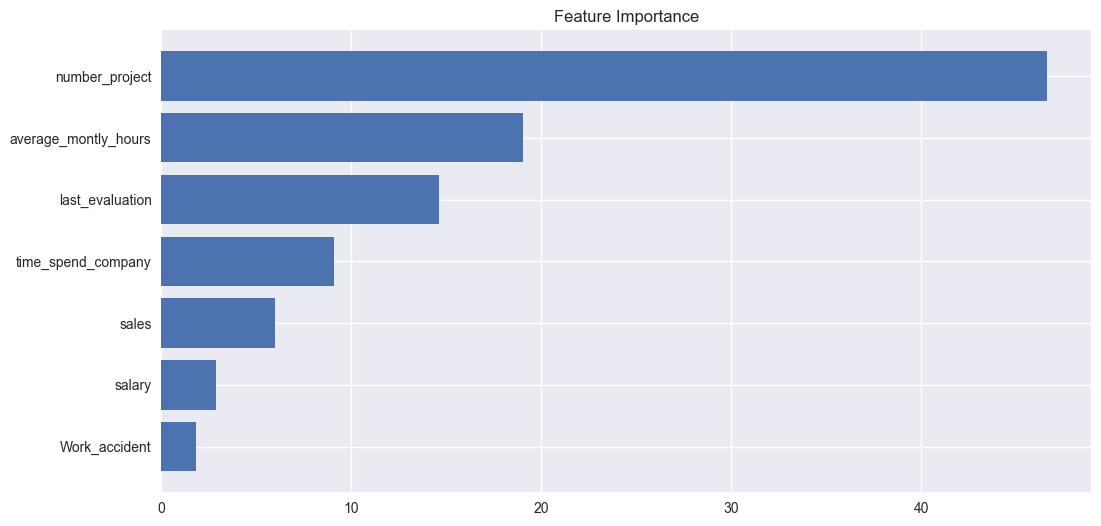

In [205]:
# Plotting feature importance

feature_importance = cat_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 6))
plt.barh(np.array(df_encoded_features)[sorted_idx], feature_importance[sorted_idx])
plt.title('Feature Importance')

# **GBM - LGBM**

In [ ]:
# Find best hyperparameters for Catboost using Optuna library

def objective(trial, data = df_encoded[df_encoded_features], target = df_encoded[target]):

    # Instantiate scaler
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust', 'maxabs', None])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    elif scalers == 'maxabs':
        scaler = MaxAbsScaler()
    elif scalers == 'robust':
        scaler = RobustScaler()
    else:
        scaler = None

    # Transform data
    if scaler != None:
        data = scaler.fit_transform(data, target)
    
    # split data in training and test data
    train_x, test_x, train_y, test_y = train_test_split(data, target,
                                                        test_size=0.25,
                                                        random_state=777)
    # Suggest hyperparameters
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 20.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0, 1),
        'subsample': trial.suggest_float('subsample', 0, 1),
        'learning_rate': trial.suggest_float('learning_rate', 0, 1),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1500),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 200)
    }
    
    # Create and fit model
    model = LGBMRegressor(
        metric = "rmse",
        random_state = 777,
        verbosity = -1 ,
        early_stopping_rounds = 200,
        **param
    )

    model.fit(train_x, train_y, eval_set = [(test_x, test_y)])
    
    # Predict and estimate results
    preds = model.predict(test_x)
    rmse = root_mean_squared_error(test_y, preds)

    return rmse



# Opruna study creation for tuning
sampler_lgbm = TPESampler(multivariate = True, group = True, seed = 777)
study_lgbm = optuna.create_study(study_name = "LGBM", sampler = sampler_lgbm)
study_lgbm.optimize(objective, n_trials = 150)
trial_lgbm = study_lgbm.best_trial
params_lgbm = study_lgbm.best_trial.params

# Printing the parameters
print("Number of finished trials: ", len(study_lgbm.trials))
print("Best trial:", trial_lgbm.number)
print("  Value: ", trial_lgbm.value)
print("  Params: ")

for key, value in trial_lgbm.params.items():
    print("    {}: {}".format(key, value))

[I 2024-06-19 23:05:31,078] A new study created in memory with name: LGBM
[I 2024-06-19 23:05:31,680] Trial 0 finished with value: 0.17117856395618114 and parameters: {'scalers': None, 'n_estimators': 1398, 'reg_alpha': 0.8090138139526348, 'reg_lambda': 1.1857274872193933, 'colsample_bytree': 0.2692050664721932, 'subsample': 0.6440292920709894, 'learning_rate': 0.09337325682922837, 'max_depth': 5, 'num_leaves': 885, 'min_child_samples': 104, 'min_data_per_groups': 198}. Best is trial 0 with value: 0.17117856395618114.
[I 2024-06-19 23:05:33,276] Trial 1 finished with value: 0.18341717306156355 and parameters: {'scalers': 'standard', 'n_estimators': 412, 'reg_alpha': 0.005568912592525825, 'reg_lambda': 0.036525180752987024, 'colsample_bytree': 0.19316240563682419, 'subsample': 0.6109109313551226, 'learning_rate': 0.882808447266879, 'max_depth': 14, 'num_leaves': 380, 'min_child_samples': 54, 'min_data_per_groups': 164}. Best is trial 0 with value: 0.17117856395618114.
[I 2024-06-19 23:0

Number of finished trials:  150
Best trial: 131
  Value:  0.16841535461472143
  Params: 
    scalers: standard
    n_estimators: 1000
    reg_alpha: 1.8018464175611841
    reg_lambda: 0.001270213243176499
    colsample_bytree: 0.9371577269660699
    subsample: 0.23410704167736834
    learning_rate: 0.008575069489310295
    max_depth: 8
    num_leaves: 1405
    min_child_samples: 79
    min_data_per_groups: 19


In [ ]:
# History of optimization

optuna.visualization.plot_optimization_history(study_lgbm)

In [ ]:
# Hyperparameters to score dependency

optuna.visualization.plot_slice(study_lgbm)

In [ ]:
# Hyperparameter importances

optuna.visualization.plot_param_importances(study_lgbm)

In [ ]:
# Implementing scaler
del params_lgbm['scalers']

scaler_lgbm = StandardScaler()
lgbm = LGBMRegressor( 
        metric = "rmse",
        random_state = 777,
        verbosity = -1 ,
        **params_lgbm)

# Create pipeline
pipeline_lgbm = make_pipeline(scaler_lgbm, lgbm)

In [ ]:
# Perform cross validation

scores_lgbm = cross_val_score(pipeline_lgbm, df_encoded[df_encoded_features], df_encoded[target],  scoring = 'neg_root_mean_squared_error') * (-1)
score_mean_lgbm = scores_lgbm.mean()
print(scores_lgbm, "Средняя оценка:", score_mean_lgbm)

[0.16729149 0.16418978 0.16808031 0.16761677 0.17065567] Средняя оценка: 0.16756680505718508


# **GBM - XGBoost**

In [131]:
# Find best hyperparameters for Catboost using Optuna library

def objective(trial, data = df_encoded[df_encoded_features], target = df_encoded[target]):

    # Instantiate scaler
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust', 'maxabs', None])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    elif scalers == 'maxabs':
        scaler = MaxAbsScaler()
    elif scalers == 'robust':
        scaler = RobustScaler()
    else:
        scaler = None

    # Transform data
    if scaler != None:
        data = scaler.fit_transform(data, target)
    
    # split data in training and test data
    train_x, test_x, train_y, test_y = train_test_split(data, target,
                                                        test_size=0.25,
                                                        random_state=777)
    # Suggest hyperparameters
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 20.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0, 1),
        'subsample': trial.suggest_float('subsample', 0, 1),
        'learning_rate': trial.suggest_float('learning_rate', 0, 1),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1500),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 200)
    }
    
    # Create and fit model
    model = LGBMRegressor(
        metric = "rmse",
        random_state = 777,
        verbosity = -1 ,
        early_stopping_rounds = 200,
        **param
    )

    model.fit(train_x, train_y, eval_set = [(test_x, test_y)])
    
    # Predict and estimate results
    preds = model.predict(test_x)
    rmse = root_mean_squared_error(test_y, preds)

    return rmse



# Opruna study creation for tuning
sampler_lgbm = TPESampler(multivariate = True, group = True, seed = 777)
study_lgbm = optuna.create_study(study_name = "LGBM", sampler = sampler_lgbm)
study_lgbm.optimize(objective, n_trials = 150)
trial_lgbm = study_lgbm.best_trial
params_lgbm = study_lgbm.best_trial.params

# Printing the parameters
print("Number of finished trials: ", len(study_lgbm.trials))
print("Best trial:", trial_lgbm.number)
print("  Value: ", trial_lgbm.value)
print("  Params: ")

for key, value in trial_lgbm.params.items():
    print("    {}: {}".format(key, value))

[I 2024-06-19 23:05:31,078] A new study created in memory with name: LGBM
[I 2024-06-19 23:05:31,680] Trial 0 finished with value: 0.17117856395618114 and parameters: {'scalers': None, 'n_estimators': 1398, 'reg_alpha': 0.8090138139526348, 'reg_lambda': 1.1857274872193933, 'colsample_bytree': 0.2692050664721932, 'subsample': 0.6440292920709894, 'learning_rate': 0.09337325682922837, 'max_depth': 5, 'num_leaves': 885, 'min_child_samples': 104, 'min_data_per_groups': 198}. Best is trial 0 with value: 0.17117856395618114.
[I 2024-06-19 23:05:33,276] Trial 1 finished with value: 0.18341717306156355 and parameters: {'scalers': 'standard', 'n_estimators': 412, 'reg_alpha': 0.005568912592525825, 'reg_lambda': 0.036525180752987024, 'colsample_bytree': 0.19316240563682419, 'subsample': 0.6109109313551226, 'learning_rate': 0.882808447266879, 'max_depth': 14, 'num_leaves': 380, 'min_child_samples': 54, 'min_data_per_groups': 164}. Best is trial 0 with value: 0.17117856395618114.
[I 2024-06-19 23:0

Number of finished trials:  150
Best trial: 131
  Value:  0.16841535461472143
  Params: 
    scalers: standard
    n_estimators: 1000
    reg_alpha: 1.8018464175611841
    reg_lambda: 0.001270213243176499
    colsample_bytree: 0.9371577269660699
    subsample: 0.23410704167736834
    learning_rate: 0.008575069489310295
    max_depth: 8
    num_leaves: 1405
    min_child_samples: 79
    min_data_per_groups: 19


In [127]:
# History of optimization

optuna.visualization.plot_optimization_history(study_lgbm)

In [133]:
# Hyperparameters to score dependency

optuna.visualization.plot_slice(study_lgbm)

In [129]:
# Hyperparameter importances

optuna.visualization.plot_param_importances(study_lgbm)

In [155]:
# Implementing scaler
del params_lgbm['scalers']

scaler_lgbm = StandardScaler()
lgbm = LGBMRegressor( 
        metric = "rmse",
        random_state = 777,
        verbosity = -1 ,
        **params_lgbm)

# Create pipeline
pipeline_lgbm = make_pipeline(scaler_lgbm, lgbm)

In [156]:
# Perform cross validation

scores_lgbm = cross_val_score(pipeline_lgbm, df_encoded[df_encoded_features], df_encoded[target],  scoring = 'neg_root_mean_squared_error') * (-1)
score_mean_lgbm = scores_lgbm.mean()
print(scores_lgbm, "Средняя оценка:", score_mean_lgbm)

[0.16729149 0.16418978 0.16808031 0.16761677 0.17065567] Средняя оценка: 0.16756680505718508
